In [745]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [746]:
df = pd.read_csv("Food_Delivery_Times.csv")

Task 1: Data Exploration and Cleaning


In [747]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [748]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [749]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


Using `.describe()`, `.info()`, and `.head()`, we can get an overview of the dataset’s structure, summary statistics, and sample data.  

**Dataset Insights**  
- The dataset contains delivery-related information, including details about traffic conditions, weather, and the delivery person.  
- Columns like Traffic_Level, Weather, Time_of_Day describe external factors affecting deliveries.  
- Other columns provide delivery person details such as experience in years and vehicle transport.  
- The dataset could be used for predictive modeling such as estimating delivery times or analyzing the impact of various conditions on delivery time.


In [750]:
# identify missing values
df.isnull().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [751]:
# separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('Order_ID')  # Exclude 'Order_ID'
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

In [752]:
# One-liner for all numerical columns
df[numerical_columns] = df[numerical_columns].interpolate(method='linear')

# One-liner for all categorical columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])
    
df.isnull().sum()

Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

In [753]:
# drops columns with more than 50% missing values
df = df.dropna(thresh=len(df) * 0.5, axis=1)

In [754]:
# Drop outliers using IQR
# Outliers are extreme values that lie far away from the majority of the data. The IQR method identifies these extreme values as data points that are too far from the "middle 50%" of the data distribution.
# The IQR method identifies these extreme values as data points that are too far from the "middle 50%" of the data distribution.


def remove_outliers(df, columns):
    outliers = pd.DataFrame()
    outlier_info = []

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        # If outliers were found, store information about them
        if not col_outliers.empty:
            outlier_info.append({
                'Column': col,
                'Lower Bound': lower_bound,
                'Upper Bound': upper_bound,
                'Outliers Count': len(col_outliers),
                'Outliers': col_outliers[[col]]
            })

        outliers = pd.concat([outliers, col_outliers])  # Collect outliers from each column
        
        # Remove outliers from the DataFrame
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Print detailed information about the removed outliers
    if outlier_info:
        print("Outliers Removed:")
        for info in outlier_info:
            print(f"\nColumn: {info['Column']}")
            print(f"Lower Bound: {info['Lower Bound']}")
            print(f"Upper Bound: {info['Upper Bound']}")
            print(f"Outliers Count: {info['Outliers Count']}")
            print(f"\nOutliers:\n{info['Outliers']}")
    else:
        print("No outliers detected.")

    return df, outliers

df, removed_outliers = remove_outliers(df, numerical_columns)


Outliers Removed:

Column: Delivery_Time_min
Lower Bound: -4.0
Upper Bound: 116.0
Outliers Count: 6

Outliers:
     Delivery_Time_min
29                 123
127                141
379                153
452                141
784                126
924                122


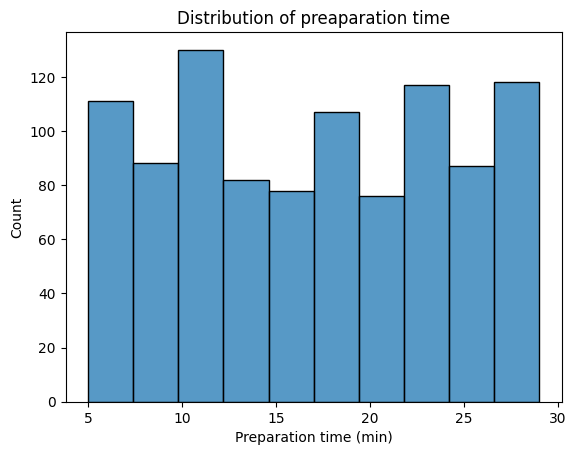

In [755]:
# Visualize
sns.histplot(df['Preparation_Time_min'], bins=10)
plt.title('Distribution of preaparation time')
plt.xlabel('Preparation time (min)')
plt.ylabel('Count')
plt.show()

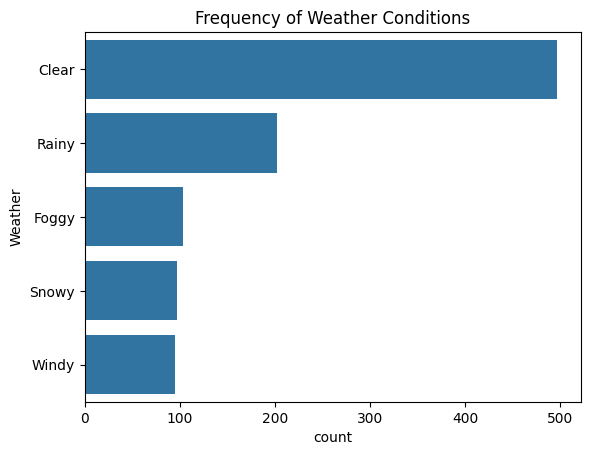

In [756]:
weather_order = df['Weather'].value_counts().index

sns.countplot(y='Weather', data=df, order=weather_order)
plt.title('Frequency of Weather Conditions')
plt.show()

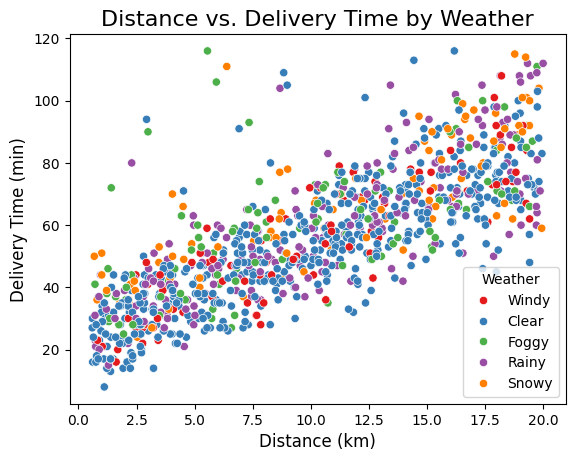

In [757]:
sns.scatterplot(x='Distance_km', y='Delivery_Time_min', hue='Weather', palette='Set1', data=df)
plt.title('Distance vs. Delivery Time by Weather', fontsize=16)
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Delivery Time (min)', fontsize=12)
plt.legend(title='Weather')
plt.show()

Task 2: Feature Engineering and Descriptive Statistics


count    994.000000
mean      10.016308
std        5.684717
min        0.590000
25%        5.015000
50%       10.150000
75%       14.890000
max       19.990000
Name: Distance_km, dtype: float64


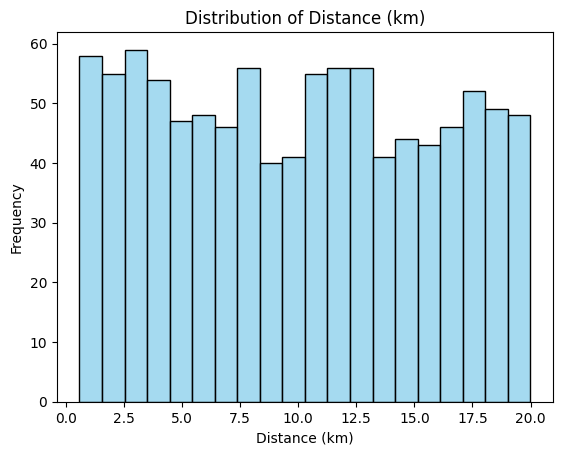

In [758]:
# binning Distance_km into categories
# first getting better understading of the distribution before binning it
print(df['Distance_km'].describe())

# Plot a histogram of Distance_km
sns.histplot(df['Distance_km'], color='skyblue', bins=20)
plt.title('Distribution of Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()


In [759]:
bins = [0, 5, 12, 25]
labels = ['low distance', 'medium distance', 'high distance']

# Create a new categorical column for the binned data
df['Distance_Group'] = pd.cut(df['Distance_km'], bins=bins, labels=labels, right=False)

# Check the result
print(df[['Distance_km', 'Distance_Group']].head())
df

   Distance_km   Distance_Group
0         7.93  medium distance
1        16.42    high distance
2         9.52  medium distance
3         7.44  medium distance
4        19.03    high distance


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Distance_Group
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43,medium distance
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84,high distance
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59,medium distance
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37,medium distance
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68,high distance
...,...,...,...,...,...,...,...,...,...,...
995,107,8.50,Clear,High,Evening,Car,13,3.0,54,medium distance
996,271,16.28,Rainy,Low,Morning,Scooter,8,9.0,71,high distance
997,861,15.62,Snowy,High,Evening,Scooter,26,2.0,81,high distance
998,436,14.17,Clear,Low,Afternoon,Bike,8,0.0,55,high distance


In [760]:
df[categorical_columns]

,Weather,Traffic_Level,Time_of_Day,Vehicle_Type
0,Windy,Low,Afternoon,Scooter
1,Clear,Medium,Evening,Bike
2,Foggy,Low,Night,Scooter
3,Rainy,Medium,Afternoon,Scooter
4,Clear,Low,Morning,Bike
...,...,...,...,...
995,Clear,High,Evening,Car
996,Rainy,Low,Morning,Scooter
997,Snowy,High,Evening,Scooter
998,Clear,Low,Afternoon,Bike


In [761]:
# Implement one-hot encoding for a categorical variable
df_encoded = pd.get_dummies(df, columns=['Weather'], prefix='Weather')

df_encoded.head()

,Order_ID,Distance_km,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Distance_Group,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy
0,522,7.93,Low,Afternoon,Scooter,12,1.0,43,medium distance,False,False,False,False,True
1,738,16.42,Medium,Evening,Bike,20,2.0,84,high distance,True,False,False,False,False
2,741,9.52,Low,Night,Scooter,28,1.0,59,medium distance,False,True,False,False,False
3,661,7.44,Medium,Afternoon,Scooter,5,1.0,37,medium distance,False,False,True,False,False
4,412,19.03,Low,Morning,Bike,16,5.0,68,high distance,True,False,False,False,False


In [762]:
# Calculate the mean, median, and standard deviation for numerical
mean_values = df[numerical_columns].mean()
median_values = df[numerical_columns].median()
std_values = df[numerical_columns].std()

# Display results
print("Mean Values:")
print(mean_values)

print("\nMedian Values:")
print(median_values)

print("\nStandard Deviation Values:")
print(std_values)


Mean Values:
Distance_km               10.016308
Preparation_Time_min      16.959759
Courier_Experience_yrs     4.576459
Delivery_Time_min         56.263581
dtype: float64

Median Values:
Distance_km               10.15
Preparation_Time_min      17.00
Courier_Experience_yrs     5.00
Delivery_Time_min         55.00
dtype: float64

Standard Deviation Values:
Distance_km                5.684717
Preparation_Time_min       7.206240
Courier_Experience_yrs     2.893366
Delivery_Time_min         21.276034
dtype: float64


In [763]:
# For categorical features, count the frequency of each category.
for col in categorical_columns:
    print(f"Frequency of categories in '{col}':")
    print(df[col].value_counts())
    print()  # line for better readability

Frequency of categories in 'Weather':
Weather
Clear    497
Rainy    202
Foggy    103
Snowy     97
Windy     95
Name: count, dtype: int64

Frequency of categories in 'Traffic_Level':
Traffic_Level
Medium    418
Low       380
High      196
Name: count, dtype: int64

Frequency of categories in 'Time_of_Day':
Time_of_Day
Morning      335
Evening      290
Afternoon    284
Night         85
Name: count, dtype: int64

Frequency of categories in 'Vehicle_Type':
Vehicle_Type
Bike       501
Scooter    300
Car        193
Name: count, dtype: int64



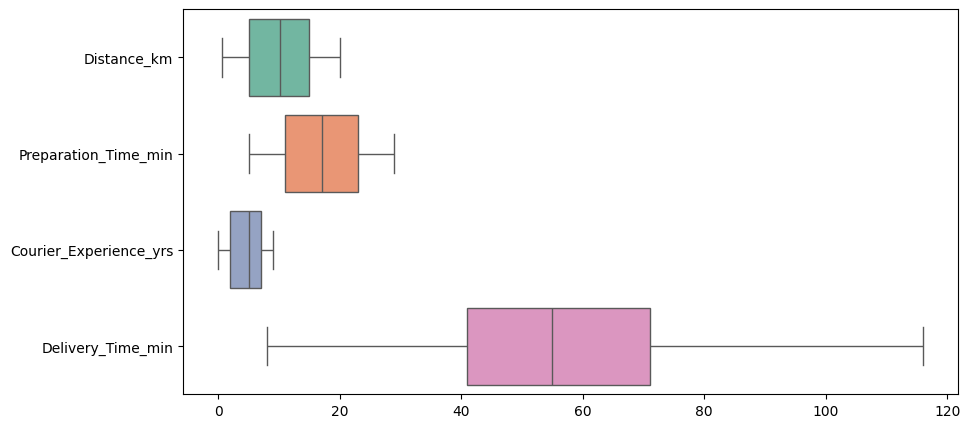

In [764]:
# Use seaborn to create box plots for numerical features to identify outliers.

# Get original data that still had outliers
df_original = pd.read_csv("Food_Delivery_Times.csv")
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[numerical_columns], orient='h', palette='Set2')
plt.show()

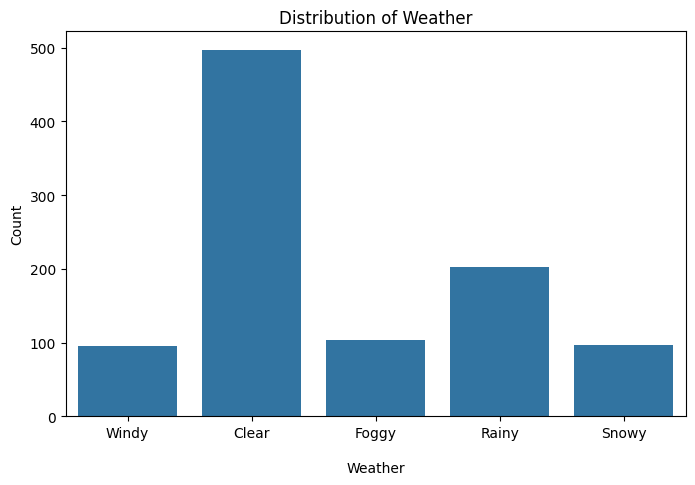

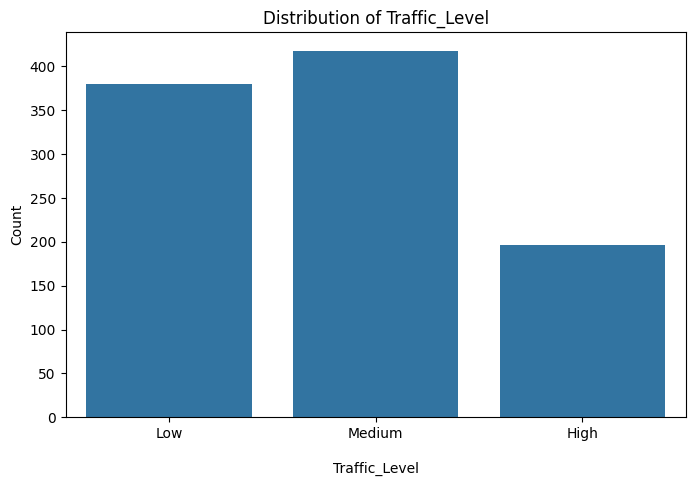

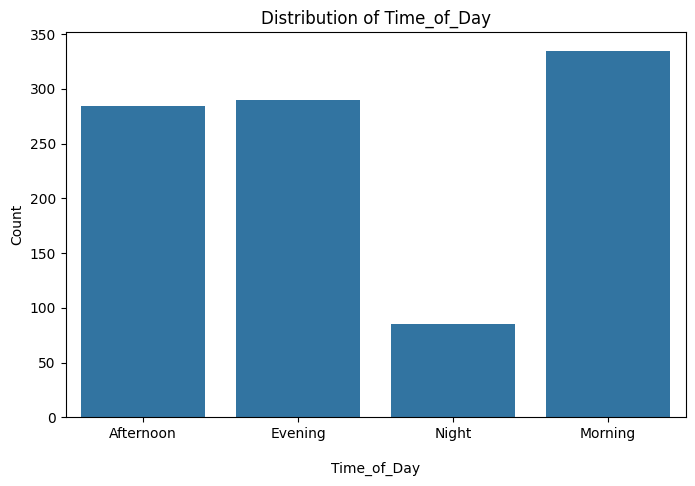

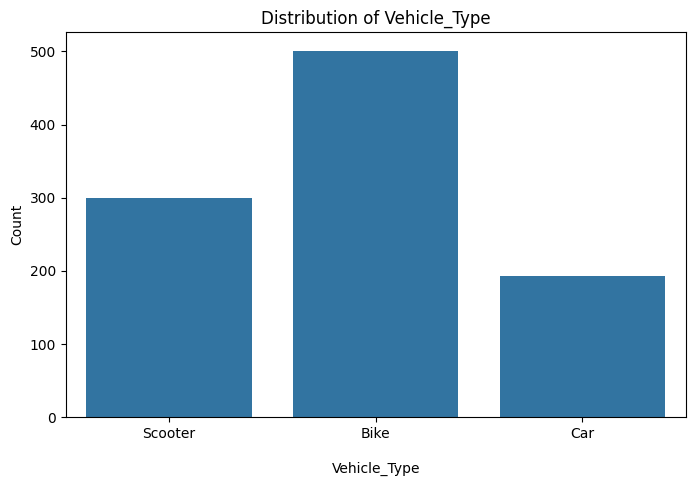

In [765]:
# Visualize the distribution of categorical features using bar plots.
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col, labelpad=15)
    plt.ylabel('Count')
    plt.show()

Task 3: Data Wrangling and Analysis

<small>How much does weather, along with other external factors like traffic and time of day, influence delivery time, and which factor has the strongest impact?</small>

In [766]:
# Select a subset of columns relevant to a hypothetical question of interest
relevant_columns = ['Traffic_Level', 'Time_of_Day', 'Weather', 'Delivery_Time_min']
df_subset = df[relevant_columns]

In [767]:
# Group by 'Weather' and calculate mean 'Delivery_Time_min'
mean_delivery_by_weather = df.groupby('Weather')['Delivery_Time_min'].mean()
print(mean_delivery_by_weather)

Weather
Clear    52.631791
Foggy    59.466019
Rainy    59.064356
Snowy    67.113402
Windy    54.757895
Name: Delivery_Time_min, dtype: float64


In [768]:
# Group by 'Traffic_Level' and calculate mean 'Delivery_Time_min'
mean_delivery_by_traffic = df_subset.groupby('Traffic_Level')['Delivery_Time_min'].mean()
print(mean_delivery_by_traffic)

Traffic_Level
High      64.515306
Low       52.228947
Medium    56.062201
Name: Delivery_Time_min, dtype: float64


In [769]:
# Group by 'Time_of_Day' and calculate mean 'Delivery_Time_min'
mean_delivery_by_time = df_subset.groupby('Time_of_Day')['Delivery_Time_min'].mean()
print(mean_delivery_by_time)

Time_of_Day
Afternoon    56.080986
Evening      56.744828
Morning      56.268657
Night        55.211765
Name: Delivery_Time_min, dtype: float64


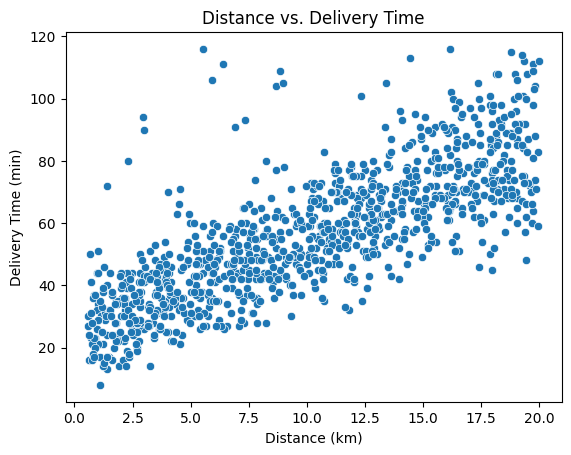

In [770]:
# Scatter plots to visualize relationships between pairs of numerical variables

sns.scatterplot(x='Distance_km', y='Delivery_Time_min', data=df)
plt.title('Distance vs. Delivery Time')
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Time (min)')
plt.show()

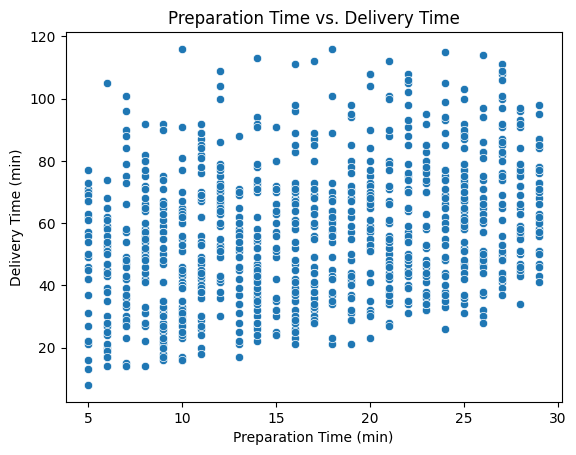

In [771]:
# Scatter plot: Preparation Time vs. Delivery Time
sns.scatterplot(x='Preparation_Time_min', y='Delivery_Time_min', data=df)
plt.title('Preparation Time vs. Delivery Time')
plt.xlabel('Preparation Time (min)')
plt.ylabel('Delivery Time (min)')
plt.show()

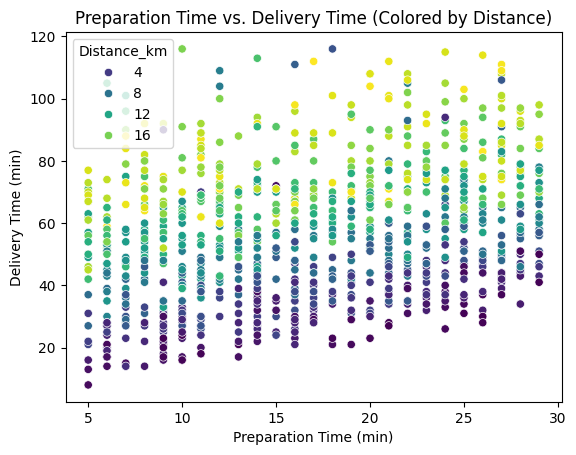

In [772]:
# Add a hue for another variable (e.g., 'Distance_km')
sns.scatterplot(x='Preparation_Time_min', y='Delivery_Time_min', hue='Distance_km', data=df, palette='viridis')
plt.title('Preparation Time vs. Delivery Time (Colored by Distance)')
plt.xlabel('Preparation Time (min)')
plt.ylabel('Delivery Time (min)')
plt.show()

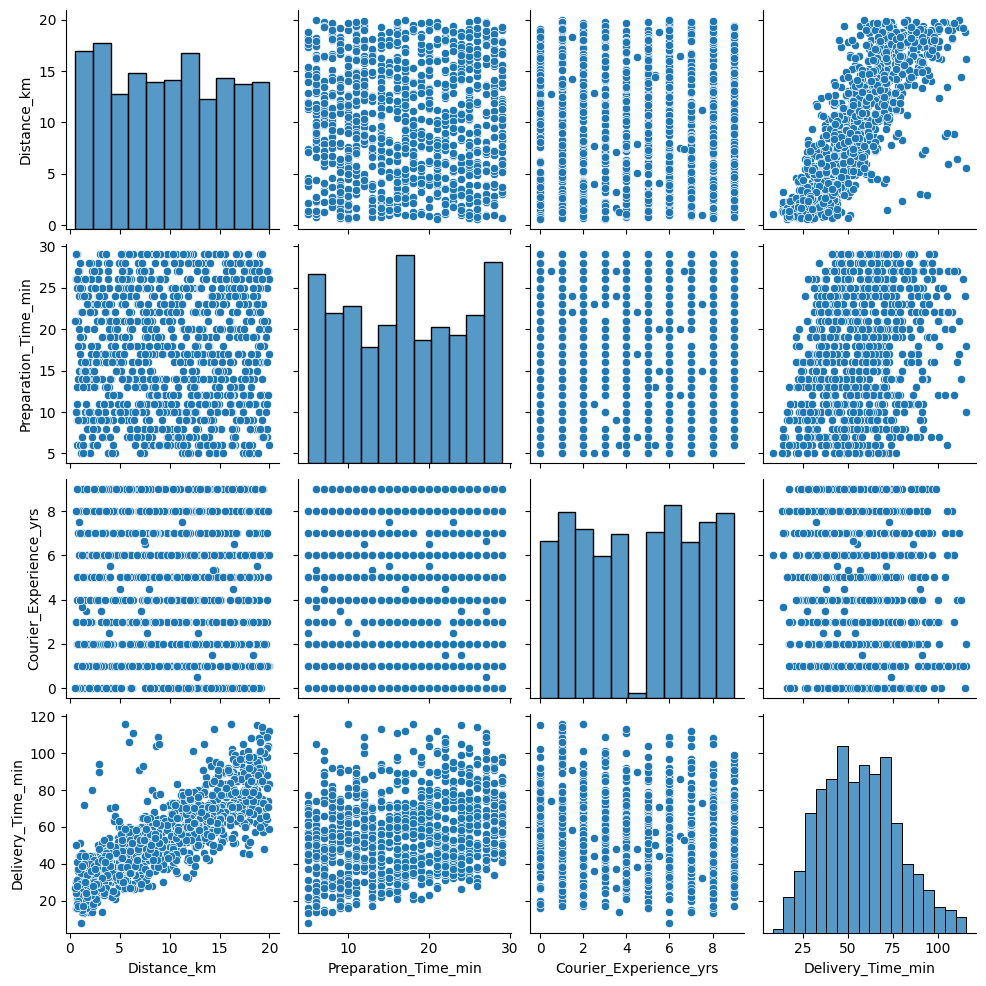

In [773]:
# Create the pairplot
sns.pairplot(df[numerical_columns])
plt.show()

**Insights based on the visualizations and descriptive statistics:**

- Weather is the most critical factor affecting delivery time, with snowy conditions causing the most significant delays.

- Traffic levels also have a significant impact on delivery time, with high traffic causing the longest delays, while medium traffic has a comparatively smaller effect.
- Time of day has a minimal effect on delivery time, with all times showing similar mean delivery times.